# Moving Average

In [1]:
# Data Handling
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Financial Data Analysis
import yfinance as yf
import ta
import quantstats as qs

# Machine Learning 
from sklearn.metrics import confusion_matrix, roc_auc_score, auc, roc_curve

# Classification ML algorithms
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif

# Oversampling minority class for imbalanced datasets
from imblearn.over_sampling import SMOTE

# Feature Importance
from sklearn.inspection import permutation_importance

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading Cocoa weekly historic data 
cocoa = yf.download('CC=F', end = datetime.today(),
                    interval = '1wk') # 1-week timeframe

cocoa.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,840.0,855.0,820.0,853.0,853.0,16820
2000-01-10,848.0,875.0,836.0,850.0,850.0,19945
2000-01-17,835.0,865.0,815.0,861.0,861.0,22502
2000-01-24,858.0,866.0,805.0,811.0,811.0,22997
2000-01-31,810.0,812.0,751.0,765.0,765.0,27492


In [3]:
# Designing Candlestick chart
candlestick = go.Candlestick(x = cocoa.index,
                            open = cocoa['Open'],
                            high = cocoa['High'],
                            low = cocoa['Low'],
                            close = cocoa['Adj Close'],
                            increasing = dict(line=dict(color = 'skyblue')),
                            decreasing = dict(line=dict(color = 'darkblue')))

In [4]:
# Defining layout
layout = go.Layout(title = {'text': '<b>Cocoa Sep 24</b> <br><sup>(Jan,2000 - Today)</sup>',
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'font': {
                               'size': 25
                           }},
                  yaxis = dict(title = 'Price (USD)'),
                  xaxis = dict(title = 'Date'),
                  template = 'ggplot2',
                  xaxis_rangeslider_visible = True,
                  yaxis_gridcolor = 'lightgray',
                  yaxis_tickfont = dict(color = 'black'),
                  xaxis_tickfont = dict(color = 'black'),
                  margin = dict(t = 80, l = 50, r = 50, b = 50),
                  height = 650, width = 1000,
                  plot_bgcolor = 'white')

fig = go.Figure(data = [candlestick], layout = layout)

In [5]:
fig.show()

In [6]:
# Splitting data into training & testing sets
train = cocoa[cocoa.index.year <= 2016] 
test = cocoa[cocoa.index.year >= 2017]

In [7]:
# Defining new features to improve the predictive power of the algorithms
def new_features(df):
    
    # Features related to price behavior
    df['high_low_ratio'] = df['High'] / df['Low']
    df['open_adjclose_ratio'] = df['Adj Close'] / df['Open']
    df['candle_to_wick_ratio'] = (df['Adj Close'] - df['Open']) / (df['High'] - df['Low'])
    upper_wick_size = df['High'] - df[['Open', 'Adj Close']].max(axis = 1)
    lower_wick_size = df[['Open', 'Adj Close']].min(axis = 1) - df['Low'] 
    df['upper_to_lower_wick_ratio'] = upper_wick_size /  lower_wick_size
    
    # Laggings
    df['lag1'] = df['Adj Close'].shift(1)
    df['lag2'] = df['Adj Close'].shift(2)
    df['lag3'] = df['Adj Close'].shift(3)
    df['lag4'] = df['Adj Close'].shift(4)
    df['lag5'] = df['Adj Close'].shift(5)
    
    # Laggings ratio
    df['close_to_lag1_ratio'] = df['Adj Close'] / df['lag1']
    df['close_to_lag2_ratio'] = df['Adj Close'] / df['lag2']
    df['close_to_lag3_ratio'] = df['Adj Close'] / df['lag3']
    df['close_to_lag4_ratio'] = df['Adj Close'] / df['lag4']
    df['close_to_lag5_ratio'] = df['Adj Close'] / df['lag5']
    
    # Exponential Moving Average: hands more weight to the most recent samples in a distribution. 
    # It captures changes and trends much faster than the simple moving average.
    # However, it gives false signals more often than the simple moving average.
    df['ema2'] = ta.trend.ema_indicator(df['Adj Close'], window = 2)
    
    # Volatility features
    df['9_days_volatility'] = df['Adj Close'].pct_change().rolling(window = 9).std()
    df['20_days_volatility'] = df['Adj Close'].pct_change().rolling(window = 20).std()
    df['9_to_20_day_vol_ratio'] = df['9_days_volatility'] / df['20_days_volatility']
    
    # Technical indicators
    df['rsi'] = ta.momentum.RSIIndicator(df['Adj Close']).rsi()
    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['cci'] = ta.trend.cci(df['High'], df['Low'], df['Adj Close'], window=10, constant=0.015)
    df['obv'] = ta.volume.OnBalanceVolumeIndicator(close=df['Adj Close'], volume=df['Volume']).on_balance_volume()
    df['obv_divergence_5_days'] = df['obv'].diff().rolling(10).sum() - df['Adj Close'].diff().rolling(5).sum()
    df['obv_divergence_10_days'] = df['obv'].diff().rolling(20).sum() - df['Adj Close'].diff().rolling(10).sum()
    df['ADX'] = ta.trend.ADXIndicator(df['High'], df['Low'], df['Adj Close'], window = 10).adx()
    df['ADI'] = ta.volume.AccDistIndexIndicator(df['High'], df['Low'], df['Adj Close'], df['Volume']).acc_dist_index()
    
    # Weekly returns
    df['returns'] = np.round((df['Adj Close'].pct_change()) * 100, 2)
    
    # Ratio between the closing price and the 8-period exponential moving average
    # When < 1 --> prices are being traded below the moving average --> a possible downtrend
    df['close_to_ema2_ratio'] = df['Adj Close'] / df['ema2']
    
    # Replacing infinite values by zeros
    df = df.replace([np.inf, -np.inf], 0)
    
    # Removing NaN values
    df = df.dropna()
    return df

In [8]:
# Applyig new_features function to both datasets
train = new_features(train)
test = new_features(test)

In [9]:
train.tail() # Displaying results

,Open,High,Low,Close,Adj Close,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,upper_to_lower_wick_ratio,...,rsi_overbought,rsi_oversold,cci,obv,obv_divergence_5_days,obv_divergence_10_days,ADX,ADI,returns,close_to_ema2_ratio
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-28,2414.0,2433.0,2343.0,2388.0,2388.0,39,1.038412,0.989229,-0.288889,0.422222,...,0,1,-103.880104,78918,-146640.0,-143235.0,35.071864,-924313.961694,-1.28,0.993832
2016-12-05,2356.0,2356.0,2213.0,2163.0,2163.0,57,1.064618,0.918081,-1.349650,-0.000000,...,0,1,-128.557706,78861,-42378.0,-21445.0,38.547679,-924410.821834,-9.42,0.964359
2016-12-12,2236.0,2308.0,2175.0,2238.0,2238.0,55913,1.061149,1.000894,0.015038,1.147541,...,0,1,-109.323501,134774,-85370.0,134954.0,41.847619,-927353.611308,3.47,0.999265
2016-12-19,2271.0,2308.0,2181.0,2264.0,2264.0,61321,1.058230,0.996918,-0.055118,0.445783,...,0,1,-89.837327,196095,101029.0,29264.0,44.817565,-908522.753040,1.16,1.003598
2016-12-26,2264.0,2272.0,2121.0,2126.0,2126.0,47721,1.071193,0.939046,-0.913907,1.600000,...,0,1,-107.110486,148374,-33532.0,58616.0,47.774653,-953083.421914,-6.10,0.980042


In [10]:
# Setting Candlestick chart
candlestick = go.Candlestick(x = train.index,
                            open = train['Open'],
                            high = train['High'],
                            low = train['Low'],
                            close = train['Adj Close'],
                            increasing = dict(line=dict(color = 'skyblue')),
                            decreasing = dict(line=dict(color = 'darkblue')),
                            name = 'Candles')

# Setting moving average on plot
ema2 = go.Scatter(x = train.index,
                 y = train['ema2'],
                 mode = 'lines',
                 line=dict(color='orange', width = 2),
                 name = 'EMA')

# Defining the overall layout
layout = go.Layout(title = {'text': '<b>Cocoa Sep 24</b> <br><sup>(Jan,2000 - Dec, 2012)</sup>',
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'font': {
                               'size': 25
                           }},
                  yaxis = dict(title = 'Price (USD)'),
                  xaxis = dict(title = 'Date'),
                  template = 'ggplot2',
                  xaxis_rangeslider_visible = True,
                  yaxis_gridcolor = 'lightgray',
                  yaxis_tickfont = dict(color = 'black'),
                  xaxis_tickfont = dict(color = 'black'),
                  margin = dict(t = 80, l = 50, r = 50, b = 50),
                  height = 650, width = 1000,
                  plot_bgcolor = 'white')

fig = go.Figure(data = [candlestick, ema2], layout = layout)

fig.show()

In [12]:
# Boxplot 
fig = px.box(train, x = 'close_to_ema2_ratio', points = 'all')

# Layout
fig.update_traces(boxpoints = 'all', marker_color = 'lightsteelblue')
fig.update_layout(height = 350, width = 1000,
                 template = 'plotly_white',
                  title = {'text': '<b>Close-to-Exponential Moving Average 2 Ratio - Boxplot</b>',
                  'x': 0.5,
                  'xanchor': 'center',
                  'yanchor': 'top',
                  'font': {
                      'size': 25
                  }},
                  margin = dict(t=100)
                 )

fig.show()

In [13]:
# Obtaining the mean of returns by range in the 'close_to_ema2_ratio' attribute
octiles = np.arange(0, 1.05, 0.05)
octile_intervals = np.quantile(train['close_to_ema2_ratio'],
                              octiles)
ranges = pd.cut(train['close_to_ema2_ratio'], octile_intervals)
data = pd.DataFrame({'ranges': ranges,
                    'returns': train['returns']})
mean_values = data.groupby('ranges')['returns'].mean()

crosstab = pd.crosstab(index = mean_values.index,
                      columns = 'mean_returns',
                      values = mean_values.values,
                      aggfunc = 'mean')
crosstab

col_0,mean_returns
row_0,
"(0.928, 0.976]",-8.133023
"(0.976, 0.981]",-5.700233
"(0.981, 0.985]",-3.953721
"(0.985, 0.988]",-3.303721
"(0.988, 0.991]",-2.723488
"(0.991, 0.993]",-2.168837
"(0.993, 0.995]",-1.251860
"(0.995, 0.997]",-1.442093
"(0.997, 0.999]",-0.290930


In [14]:
# Creating target variable
def target(df):
    df['target'] = np.where(df['close_to_ema2_ratio'] <= 0.999, 0, 1)
    df['target'] = df['target'].shift(-1) 
    # shift the target variable one sample backwards to capture the characteristics of the current week that culminated in a value of 1 or 0 in the following week
    df = df.dropna()
    return df

In [15]:
# Applying function
train = target(train)
test = target(test)

In [16]:
train.head() # Displaying results

,Open,High,Low,Close,Adj Close,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,upper_to_lower_wick_ratio,...,rsi_oversold,cci,obv,obv_divergence_5_days,obv_divergence_10_days,ADX,ADI,returns,close_to_ema2_ratio,target
Date,,,,,,,,,,,,,,,,,,,,,
2000-05-22,853.0,874.0,821.0,835.0,835.0,25946,1.064555,0.978898,-0.339623,1.500000,...,0,99.756691,-113096,-76392.0,-129853.0,12.272928,-36399.533314,-2.57,1.002114,1.0
2000-05-29,835.0,858.0,828.0,848.0,848.0,14958,1.036232,1.015569,0.433333,1.428571,...,0,108.115859,-98138,-34788.0,-95021.0,13.549811,-31413.533314,1.56,1.005836,1.0
2000-06-05,843.0,885.0,806.0,849.0,849.0,35038,1.098015,1.007117,0.075949,0.972973,...,0,91.464968,-63100,30306.0,-82526.0,15.606744,-28308.900402,0.12,1.002330,1.0
2000-06-12,845.0,866.0,838.0,849.0,849.0,27378,1.033413,1.004734,0.142857,2.428571,...,0,82.196970,-35722,37191.0,-32141.0,17.457984,-34175.614688,0.00,1.000775,0.0
2000-06-19,850.0,905.0,810.0,825.0,825.0,1199,1.117284,0.970588,-0.263158,3.666667,...,0,60.351029,-36921,70903.0,-5827.0,20.294136,-34995.983109,-2.83,0.990657,0.0


In [17]:
# Pie plot
fig = px.pie(train, names = 'target', hole = .5)

# Layout
fig.update_traces(marker=dict(colors=['red', 'blue']))

fig.update_layout(title = {'text':'<b>Distribution of Classes in the Target Variable</b>',
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'font': {
                               'size': 25
                           }},
                  margin=dict(t=100)
                 )
fig.show()

In [18]:
# Splitting data into Independent Features X and Target Variable y
X_train = train.drop('target', axis = 1)
y_train = train.target

X_test = test.drop('target', axis = 1)
y_test = test.target

In [19]:
# Applying oversampling using SMOTE
smote = SMOTE(random_state = 30) # balance the class distribution in your training data.

X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train,y_train)

In [20]:
# Pie plot
fig = px.pie(y_train_oversampled, names = y_train_oversampled.values, hole = .5)
fig.update_traces(marker=dict(colors=['red', 'blue']))

# Layout
fig.update_layout(title = {'text':'<b>Distribution of Classes in the Target Variable</b><br><sup>(After Oversampling)</sup>',
                           'x': 0.5,
                           'xanchor': 'center',
                           'yanchor': 'top',
                           'font': {
                               'size': 25
                           }},
                  margin=dict(t=100)
                 )
fig.show()

In [21]:
# Selecting Features using SelectKBest
# Identify the most relevant features according to its k score
k_best = SelectKBest(score_func = f_classif,
                     k = len(X_train.columns))

# Fitting and transforming data
X_train_best = k_best.fit_transform(X_train, y_train)
X_test_best = k_best.transform(X_test)

feat_indices = k_best.get_support(indices = True)
feat_names = X_train.columns[feat_indices]

p_values = k_best.pvalues_

selected_features = []

for feature, pvalue in zip(feat_names, p_values):
    if pvalue < 0.01: # p-value < 1% as threshold
        selected_features.append(feature)
        
print("Selected Features: \n")
print(selected_features)

Selected Features: 

['open_adjclose_ratio', 'candle_to_wick_ratio', 'close_to_lag1_ratio', 'close_to_lag2_ratio', 'close_to_lag3_ratio', 'close_to_lag4_ratio', 'close_to_lag5_ratio', 'rsi', 'cci', 'returns', 'close_to_ema2_ratio']


In [22]:
# Selecting only the best features
X_train_best = X_train[selected_features]
X_test_best = X_test[selected_features]

In [23]:
# Creating list of classifiers
classifiers = [
    LogisticRegression(random_state = 30),
    XGBClassifier(random_state = 30),
    LGBMClassifier(random_state = 30),
    # CatBoostClassifier(random_state = 30, verbose = False),
    AdaBoostClassifier(random_state = 30),
    RandomForestClassifier(random_state = 30),
    GradientBoostingClassifier(random_state = 30),
    MLPClassifier(random_state = 30)
]

# Iterating over classifiers and computing AUC (Area Under the ROC Curve score)
for clf in classifiers:
    clf.fit(X_train_best, y_train)
    preds = clf.predict_proba(X_test_best)[:,1]
    auc_score = roc_auc_score(y_test, preds)
    print(f'{type(clf).__name__}: AUC Score = {auc_score:.3f}')

LogisticRegression: AUC Score = 0.696
XGBClassifier: AUC Score = 0.608
[LightGBM] [Info] Number of positive: 479, number of negative: 381
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2805
[LightGBM] [Info] Number of data points in the train set: 860, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.556977 -> initscore=0.228901
[LightGBM] [Info] Start training from score 0.228901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBMClassifier: AUC Score = 0.616
AdaBoostClassifier: AUC Score = 0.621
RandomForestClassifier: AUC Score = 0.651
GradientBoostingClassifier: AUC Score = 0.628
MLPClassifier: AUC Score = 0.685


In [24]:
# Building best model
model = LogisticRegression(random_state = 30)
model.fit(X_train_best, y_train)
y_pred = model.predict_proba(X_test_best)[:,1]

# Computing AUC score
fpr, tpr, thersholds = roc_curve(y_test, y_pred)
auc_score = auc(fpr, tpr)

# Plotting the AUC-ROC Plot
fig = go.Figure()

# Area Under the Curve
fig.add_trace(go.Scatter(x = fpr,
                        y = tpr,
                        mode = 'lines',
                        fill = 'tozeroy',
                        line=dict(color = 'cornflowerblue', width = 2),
                        name = f'AUC = {auc_score:.3f}'))

In [25]:
# Random Guess line
fig.add_trace(go.Scatter(x = [0,1],
                       y = [0,1],
                       mode = 'lines',
                       line=dict(color = 'indigo', width = 1.5, dash = 'longdashdot'),
                       name = 'Random Guess'))

# Layout
fig.update_layout(xaxis = dict(range=[0.0, 1.0]),
                 yaxis = dict(range=[0.0, 1.05]),
                 xaxis_title = 'False Positive Rate',
                 yaxis_title = 'True Positive Rate',
                 title = {
                     'text':'<b>Area Under the Curve - Logistic Regression Model</b>',
                     'x': 0.5,
                     'xanchor': 'center',
                     'yanchor': 'top',
                     'font': {
                         'size': 25
                     }
                 },
                 margin = dict(t = 180),
                 legend = dict(x=1, y=1, xanchor = 'right', yanchor = 'bottom'),
                 plot_bgcolor = 'white',
                 showlegend = True,
                 height = 650, width = 1000)
fig.show() # Displaying figure

In [26]:
result = permutation_importance(model, X_test_best, y_test, n_repeats=100, random_state=30) # Computing feature importance

# Computing mean scores and obtaining features' names
importances = result.importances_mean
feature_names = X_test_best.columns

# Sorting Features importances and names
indices = importances.argsort()[::1]
sorted_features = feature_names[indices]
sorted_importances = importances[indices]

# Plotting Feature Importance
fig = go.Figure()

fig.add_trace(go.Bar(x = sorted_importances,
                    y = sorted_features,
                    marker = dict(color = 'steelblue'),
                    orientation = 'h'))

fig.update_layout(title = {'text':'<b>Logistic Regression - Feature Importance</b>',
                          'x': 0.5,
                          'xanchor': 'center',
                          'yanchor': 'top',
                          'font': {
                              'size': 25
                          }},
                 margin = dict(t = 100),
                 xaxis_title = 'Importance',
                 yaxis_title = 'Features',
                 showlegend = False,
                 height = 750,
                 width = 1000,
                 plot_bgcolor = 'white')
fig.show()

In [27]:
y_pred # Displaying probabilities

array([0.33444065, 0.68409784, 0.58354529, 0.4689418 , 0.31702346,
       0.44705161, 0.62447332, 0.71905331, 0.70395313, 0.43596233,
       0.52394289, 0.42414831, 0.6105842 , 0.6077039 , 0.52592497,
       0.60918562, 0.50331489, 0.64324376, 0.62029914, 0.54960648,
       0.62743585, 0.51140689, 0.4575036 , 0.78509192, 0.41007351,
       0.51433287, 0.44050984, 0.31355455, 0.53526581, 0.43936619,
       0.70685897, 0.57609433, 0.5816499 , 0.58243009, 0.63916357,
       0.66909718, 0.49486609, 0.70963894, 0.71543091, 0.77034883,
       0.62539538, 0.67582668, 0.47841079, 0.40973491, 0.70482567,
       0.79196537, 0.69271736, 0.49688398, 0.55789812, 0.40548215,
       0.40094284, 0.43287933, 0.47730848, 0.77525217, 0.49067446,
       0.53805794, 0.53441317, 0.62392615, 0.30110349, 0.41790705,
       0.27902156, 0.61766543, 0.61876118, 0.88209569, 0.49823239,
       0.47164743, 0.43134736, 0.4553006 , 0.3761992 , 0.4959437 ,
       0.76670282, 0.57269022, 0.68422973, 0.57165522, 0.50499

In [28]:
octiles = np.arange(0, 1.125, 0.125)
intervals = np.quantile(y_pred, octiles)
classes = pd.cut(y_pred, intervals)
table = pd.crosstab(classes, y_test)
table

target,0.0,1.0
row_0,,
"(0.0357, 0.436]",32,13
"(0.436, 0.481]",27,18
"(0.481, 0.526]",19,26
"(0.526, 0.569]",24,21
"(0.569, 0.603]",14,31
"(0.603, 0.638]",12,33
"(0.638, 0.71]",11,34
"(0.71, 0.979]",9,37


In [29]:
# Creating sign
sign = np.where((y_pred <= 0.569), -1, 1)
sign # Visualizing results

array([-1,  1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1,
        1,  1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
        1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1,  1,  1, -1, -1, -1, -1,
       -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1,
       -1, -1,  1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1,  1,
        1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,  1, -1,  1,  1,  1,
       -1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1,
        1, -1,  1, -1, -1, -1, -1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,
       -1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1, -1, -1,
        1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1,  1, -1, -1,
       -1, -1, -1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1, -1, -1, -1, -1

In [30]:
X_test['sign'] = sign # Model's predictions for next week
X_test['position'] = X_test['sign'].shift(1) # Current position
X_test['model_returns'] = X_test['position'] * X_test['returns'] # Obtaining return according to model's predictions
X_test # Displaying results on the dataframe

,Open,High,Low,Close,Adj Close,Volume,high_low_ratio,open_adjclose_ratio,candle_to_wick_ratio,upper_to_lower_wick_ratio,...,obv,obv_divergence_5_days,obv_divergence_10_days,ADX,ADI,returns,close_to_ema2_ratio,sign,position,model_returns
Date,,,,,,,,,,,,,,,,,,,,,
2017-05-22,2034.0,2058.0,1867.0,1911.0,1911.0,101352,1.102303,0.939528,-0.643979,0.545455,...,-822946,-428055.0,-896720.0,29.859973,-4.602490e+05,-5.77,0.982444,-1,NaN,NaN
2017-05-29,1922.0,2060.0,1920.0,2001.0,2001.0,129787,1.072917,1.041103,0.564286,29.500000,...,-693159,-408398.0,-679875.0,28.682573,-4.398539e+05,4.71,1.009391,1,-1.0,-4.71
2017-06-05,2003.0,2053.0,1927.0,2020.0,2020.0,166281,1.065387,1.008487,0.134921,0.434211,...,-526878,-150490.0,-426449.0,27.622913,-3.606724e+05,0.95,1.006246,1,1.0,0.95
2017-06-12,2030.0,2083.0,1971.0,1975.0,1975.0,69220,1.056824,0.972906,-0.491071,13.250000,...,-596098,-73735.0,-397986.0,25.969002,-4.249481e+05,-2.23,0.994551,-1,1.0,-2.23
2017-06-19,1975.0,1987.0,1769.0,1843.0,1843.0,495,1.123233,0.933165,-0.605505,0.162162,...,-596593,6535.0,-272012.0,27.212897,-4.251071e+05,-6.68,0.974819,-1,-1.0,6.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,9331.0,10098.0,9103.0,9933.0,9933.0,71189,1.109305,1.064516,0.605025,0.723684,...,3154646,313571.0,1095247.0,51.746930,1.237173e+06,6.45,1.033504,1,1.0,6.45
2024-06-10,9933.0,11000.0,9411.0,10294.0,10294.0,33438,1.168845,1.036344,0.227187,1.352490,...,3188084,261605.0,943436.0,49.848972,1.240897e+06,3.63,1.022617,1,1.0,3.63
2024-06-17,10225.0,10307.0,8600.0,8995.0,8995.0,9355,1.198488,0.879707,-0.720562,0.207595,...,3178729,182964.0,773245.0,46.590886,1.235872e+06,-12.62,0.961815,-1,1.0,-12.62


In [31]:
# Obtaining decimal values
model = X_test['model_returns'] / 100
buy_hold = X_test['returns'] / 100

In [32]:
t_bill_data = yf.download('^IRX', period='1d')  # Fetch the latest available data

# Preprocess the data to get the latest risk-free rate
latest_rf_rate = t_bill_data['Close'].iloc[-1] / 100  # Convert percentage to proportion

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  -----------
Start Period               2017-06-05   2017-06-05
End Period                 2024-07-01   2024-07-01
Risk-Free Rate             5.22%        5.22%
Time in Market             100.0%       100.0%

Cumulative Return          258.88%      1,135.02%
CAGR﹪                     13.28%       27.79%

Sharpe                     1.51         2.69
Prob. Sharpe Ratio         81.37%       99.4%
Smart Sharpe               1.49         2.66
Sortino                    2.32         4.94
Smart Sortino              2.29         4.88
Sortino/√2                 1.64         3.49
Smart Sortino/√2           1.62         3.45
Omega                      1.64         1.64

Max Drawdown               -46.71%      -45.25%
Longest DD Days            799          771
Volatility (ann.)          73.99%       73.25%
R^2                        0.0          0.0
Information Ratio          0.05         0.05
Calmar          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-12-20,2023-07-10,2024-01-29,771,-45.250209,-43.946077
2,2020-08-10,2020-11-02,2020-11-16,99,-22.002114,-20.933543
3,2017-08-21,2017-11-13,2018-02-26,190,-17.641619,-16.982752
4,2024-02-12,2024-02-19,2024-03-04,22,-17.626500,-14.315085
5,2018-06-11,2018-07-16,2018-08-13,64,-17.316244,-14.149457


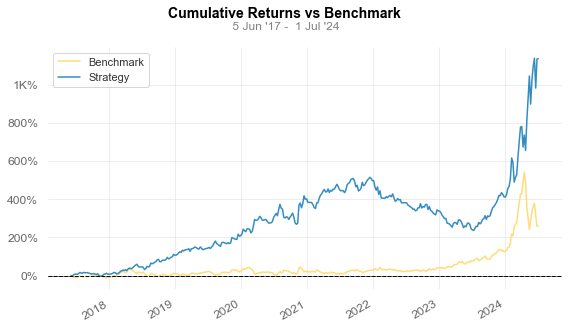

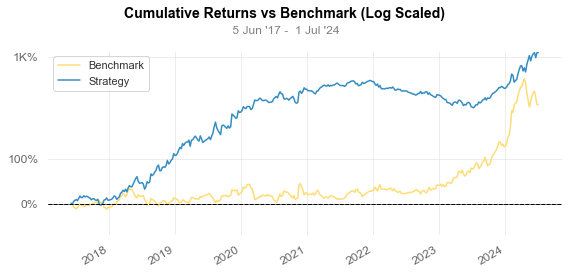

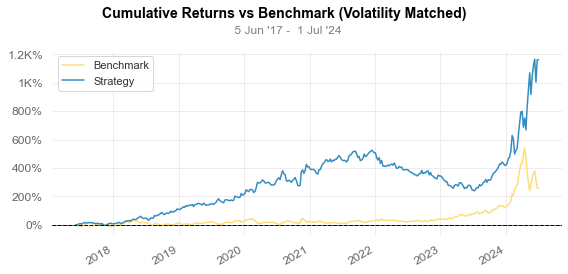

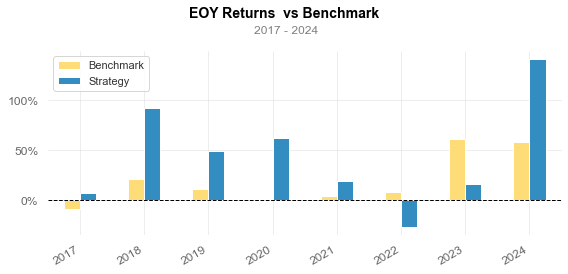

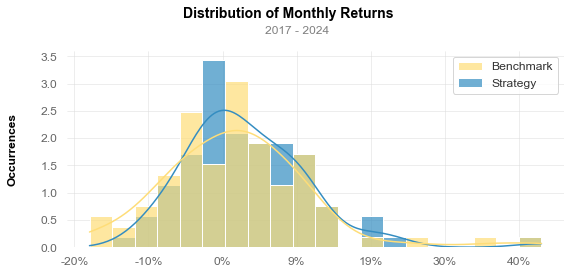

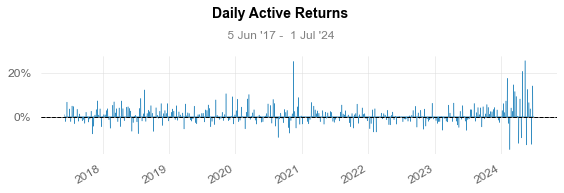

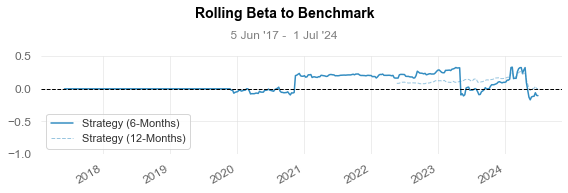

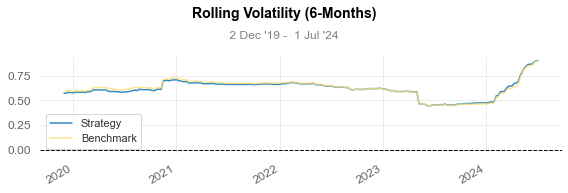

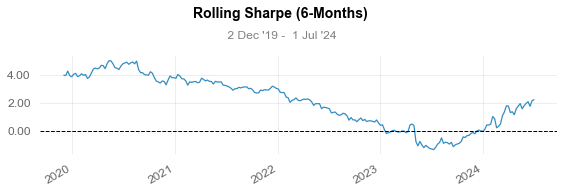

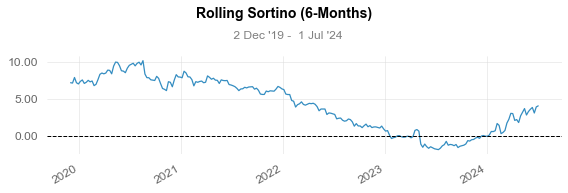

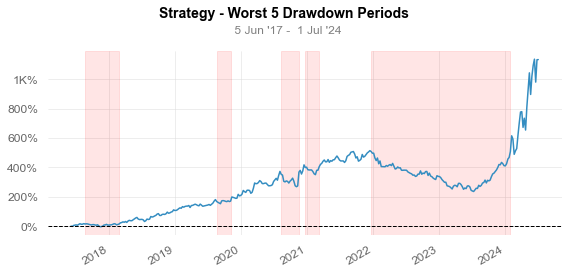

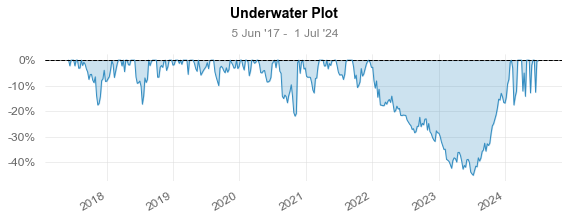

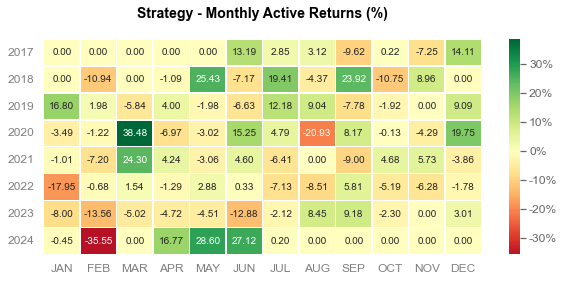

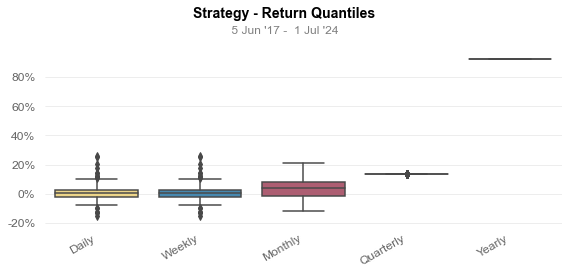

In [33]:
# Generating performance report
qs.reports.full(model,
               benchmark = buy_hold, rf=latest_rf_rate)